<a href="https://colab.research.google.com/github/felixsimard/comp551-p2/blob/main/tyler_part1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

In [5]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'logistic function')

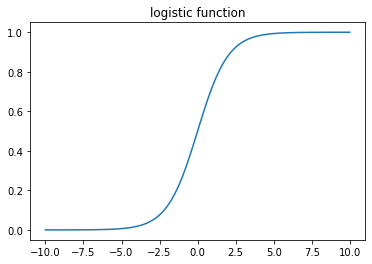

In [6]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

```
#logistic
x [N,D]
w [D]
x@w [N]
logistic(x@w) [N]

#softmax
x [N,D]  R^D->R^C
w [D,C]
logits = x@w [N,C] 
logits = logits - np.max(logits, axis=1)
softmax[j,i] = exp(logits[j,i])/{np.sum(exp(logits), axis=1)+eps}
softmax(x@w) [N,C]
```

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [7]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [8]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [9]:
import time
import pandas as pd
from sklearn.metrics import accuracy_score

In [347]:
class TrainingResults:
        
        def __init__(self, lr_model, batch_size, acc_list_it, acc_list_time, acc_list_epoch, grad_list_it, grad_list_time, grad_list_epoch, final_grad_norm, total_iter, time):
            self.lr_model = lr_model
            self.batch_size = batch_size
            self.acc_list_it = acc_list_it
            self.acc_list_time = acc_list_time
            self.acc_list_epoch = acc_list_epoch
            self.grad_list_it = grad_list_it
            self.grad_list_time = grad_list_time
            self.grad_list_epoch = grad_list_epoch
            self.final_grad_norm = final_grad_norm
            self.total_iter = total_iter
            self.time = time
            
        def __repr__(self):
            return f'''\nBatch size: {self.batch_size}\n
            Weights: {self.lr_model.w}\n
            Final gradient norm: {self.final_grad_norm}\n
            Elapsed Time: {self.time}\n
            Total iterations: {self.total_iter}
            Total epochs: {len(self.acc_list_epoch)}'''
            
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        
    def fit(self, x, y, batch_size=-1):
        if batch_size  == -1:
            batch_size = len(x)
        start_time = time.process_time()
        if x.ndim == 1:
            x = x[:, None] # 1d to 2d
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)]) # adding a new column with N rows
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        # step when exceeding max iters or gradient becomes too small
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            rand_index = np.random.choice(len(x), batch_size, replace=False)
            batch_x = x[rand_index]
            batch_y = y[rand_index]
            g = self.gradient(batch_x, batch_y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        elapsed_time = time.process_time() - start_time

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
            print(f'time elapsed: {elapsed_time: .2f} seconds')
            print()
        return self
    
    def fit_for_vis(self, x, y, val_X, val_y, itv=1e3, batch_size=-1, max_epochs=-1, momentum=0):
        if batch_size  == -1:
            batch_size = len(x)
        start_time = time.process_time()
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        print(x.shape)
        self.w = np.zeros(D)
        g = np.inf 
        t = 0

        acc_list_it = []
        acc_list_time = []
        grad_list_it = []
        grad_list_time = []
        acc_list_epoch = []
        grad_list_epoch = []
        time_itv = 0
        elapsed_time = 0
        reduced_x = x
        reduced_y = y
        epoch_done = False
        num_epochs = 0
        change = 0
        if max_epochs != -1:
            by_iters = False
            by_epochs = True
        else:
            by_iters = True
            by_epochs = False

        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and (by_epochs or t < self.max_iters) and (by_iters or num_epochs < max_epochs) :
            if t % itv == 0:
                val_yh = (self.predict(val_X) > 0.5).astype('int')
                acc_list_it.append(accuracy_score(val_y, val_yh))
                grad_list_it.append(np.linalg.norm(g))
            if elapsed_time > 15.0 * time_itv:
                val_yh = (self.predict(val_X) > 0.5).astype('int')
                acc_list_time.append(accuracy_score(val_y, val_yh))
                grad_list_time.append(np.linalg.norm(g))
                time_itv += 1
            if batch_size < len(reduced_x):
                rand_index = np.random.choice(len(reduced_x), batch_size, replace=False)
                batch_x = reduced_x[rand_index]
                batch_y = reduced_y.iloc[rand_index]
                reduced_x = np.delete(reduced_x, rand_index, axis=0)
                reduced_y = reduced_y.drop(batch_y.index)
                g = self.gradient(batch_x, batch_y)
            else:
                g = self.gradient(reduced_x, reduced_y)
                reduced_x = x
                reduced_y = y
                val_yh = (self.predict(val_X) > 0.5).astype('int')
                acc_list_epoch.append(accuracy_score(val_y, val_yh))
                grad_list_epoch.append(np.linalg.norm(g))
                num_epochs += 1
            change = momentum * change + (1 - momentum) * g
            self.w = self.w - self.learning_rate * change
            t += 1
            elapsed_time = time.process_time() - start_time
        if self.verbose:
            print(f'learning rate: {self.learning_rate}')
            print(f'batch size: {batch_size}')
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
            print(f'time elapsed: {elapsed_time: .2f} seconds')
            print()
            
        result = TrainingResults(self, batch_size, acc_list_it, acc_list_time, acc_list_epoch, grad_list_it, grad_list_time, grad_list_epoch, np.linalg.norm(g), t, elapsed_time)

        return result

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

we see that the model successfully fits the training data. If we run the optimization for long enough the weights will grow large (in absolute value) so as to make the predicted probabilities for the data-points close to the decidion boundary (x=2) close to zero and one.


# Code added

In [4]:
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# train_df = pd.read_csv('/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_train.csv')
# val_df = pd.read_csv('/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_val.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_test.csv')

Mounted at /content/drive


In [249]:
train_df = pd.read_csv('./diabetes/diabetes_train.csv')
val_df = pd.read_csv('./diabetes/diabetes_val.csv')
test_df = pd.read_csv('./diabetes/diabetes_test.csv')
# x = train_df
# N = x.shape[0]
# x = np.column_stack([x,np.ones(N)])
# reduced_x = x
# rand_index = np.random.choice(len(reduced_x), 8, replace=False)
# print(rand_index)
# batch_x = reduced_x[rand_index]
# print(reduced_x.shape)
# reduced_x = np.delete(reduced_x, rand_index, axis=0)
# print(batch_x.shape)
# print(reduced_x.shape)

In [13]:
val_df.Outcome.value_counts()

0    65
1    35
Name: Outcome, dtype: int64

## Feature-Target split

In [12]:
# split into feature and target
train_X =  train_df.drop('Outcome', axis=1)
train_y = train_df.loc[:, 'Outcome']
val_X = val_df.drop('Outcome', axis=1)
val_y = val_df.loc[:, 'Outcome']
test_X = test_df.drop('Outcome', axis=1)
test_y = test_df.loc[:, 'Outcome']

In [42]:
def get_acc_list(lr, max_iters, itv):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    acc_list, _, _, _ = model.fit_for_vis(train_X, train_y, val_X, val_y, itv)
    return acc_list

## Visualization

Try the following learning rates: [0.2, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

In [14]:
# configuration
max_iter = 1e6
itv = int(1e3)
lr_list = [0.2, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

In [15]:
# parallerize training
# accs_list = Parallel(n_jobs=-1, verbose=10)(delayed(get_acc_list)(i, max_iter, itv) for i in lr_list)
accs_list = [get_acc_list(lr_list[4], max_iter, itv)]

KeyboardInterrupt: 

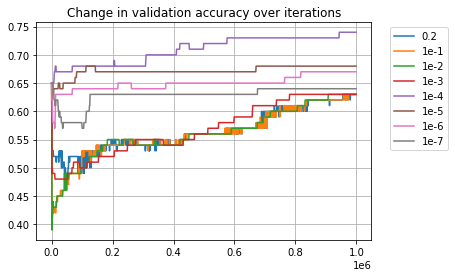

In [ ]:
# Create plot
length = len(accs_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, accs_list[i]) for i in range(len(accs_list))]
plt.legend(['0.2', '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7'],
           bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=1e6.png', bbox_inches="tight")

Now, increase the max_iters and try again with [1e-4, 1e-5, 1e-6, 1e-7].

In [104]:
# configuration
new_max_iter = 3*(1e6)
new_itv = int(1e4)
new_lr_list = [1e-4, 1e-5, 1e-6, 1e-7]

In [ ]:
new_accs_list = []
for i in range(len(new_lr_list)):
    result = get_acc_list(new_lr_list[i], new_max_iter, new_itv)
    print('\n')
    new_accs_list.append(result)

terminated after 3000000 iterations, with norm of the gradient equal to 0.009055883681953803
the weight found: [ 1.32319999e-01  2.81401475e-02 -1.66189784e-02 -2.77309928e-03
  1.51703686e-04  5.39611332e-02  6.17168404e-01  3.58746135e-03
 -5.56318969e+00]
time elapsed:  742.58 seconds


terminated after 3000000 iterations, with norm of the gradient equal to 0.030759426504308147
the weight found: [ 0.12950679  0.01574091 -0.02754224 -0.00150766  0.00131935  0.00407726
  0.17113651 -0.0096257  -0.98839465]
time elapsed:  744.93 seconds


terminated after 3000000 iterations, with norm of the gradient equal to 0.03569813470454591
the weight found: [ 0.13127481  0.01373776 -0.03063641 -0.00100074  0.00157156 -0.00478922
  0.02007397 -0.01208031 -0.10658963]
time elapsed:  741.24 seconds


terminated after 3000000 iterations, with norm of the gradient equal to 0.136915677637244
the weight found: [ 0.05221273  0.01255442 -0.0305826  -0.00097407  0.00148354 -0.00601824
  0.00166148  0.00064

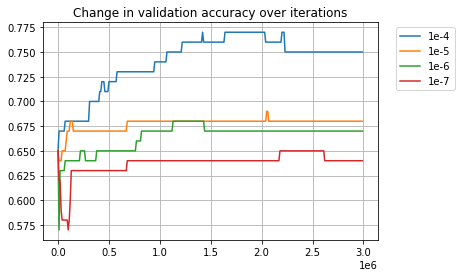

In [ ]:
# Create plot
new_length = len(new_accs_list[0])
new_row = list(range(0, new_length*new_itv, new_itv))
[plt.plot(new_row, new_accs_list[i]) for i in range(len(new_accs_list))]
plt.legend(['1e-4', '1e-5', '1e-6', '1e-7'],
           bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=3_1e6.png',
            bbox_inches="tight")

## Best Configuration
From the plot above:

max_iters = 1.8e6

lr = 1e-4

---------------------------
epsilon=1e-4 (default value) but the norm of the gradient didn't decrease below 1e-4 in my experiments, so this parameter is not tuned.

In [345]:
def get_training_results_batch(lr, max_iters, itv, batch_size, max_epochs, momentum):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    print("train x", train_X.shape)
    return model.fit_for_vis(train_X, train_y, val_X, val_y, itv, batch_size, max_epochs, momentum)

def same_length_lsts(results):
    max_time_num_itv = 0
    for r in results:
        if len(r.acc_list_time) > max_time_num_itv:
            max_time_num_itv = len(r.acc_list_time)
    for r in results:
        if len(r.acc_list_time) < max_time_num_itv:
            r.acc_list_time += [r.acc_list_time[-1]] * (max_time_num_itv - len(r.acc_list_time))
        if len(r.grad_list_time) < max_time_num_itv:
            r.grad_list_time += [r.grad_list_time[-1]] * (max_time_num_itv - len(r.grad_list_time))
    return results

In [342]:
def plot_epochs(results, num_epochs):
    epoch_row = list(range(1, num_epochs + 1))
    [plt.plot(epoch_row, results[i].acc_list_epoch) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in validation accuracy over iterations by batch size (lr = {learning_rate})")
    plt.savefig('./' + num_epochs + '_acc_epoch_batch')
    
    
def plot_results(results, lr_val):
    length = len(results[0].acc_list_it)
    it_row = list(range(1, length*itv, itv))
    time_row = list(range(0, 15*len(results[0].acc_list_time), 15))
    learning_rate = results[0].lr_model.learning_rate
    
    [plt.plot(it_row, results[i].acc_list_it) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in validation accuracy over iterations by batch size (lr = {learning_rate})")
    plt.savefig('./' + lr_val + '_acc_iter_batch')

    
    [plt.plot(time_row, results[i].acc_list_time) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Speed of accuracy convergence by batch size (lr = {learning_rate})")
    plt.savefig('./figures/' + lr_val + '_acc_speed_batch')


    [plt.plot(it_row, results[i].grad_list_it) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in gradient over iterations by batch size (lr = {learning_rate})")
    plt.savefig('./figures/' + lr_val + '_grad_iter_batch')

    
    [plt.plot(time_row, results[i].grad_list_time) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Speed of gradient convergence by batch size (lr = {learning_rate})")
    plt.savefig('./figures/' + lr_val + '_grad_speed_batch')

In [328]:
results = [ get_training_results_batch(1e-4, 3*(1e6), 1e4, batch_size, 10000) for batch_size in batch_sizes]

train x (600, 8)
(600, 9)
learning rate: 0.0001
batch size: 8
terminated after 750000 iterations, with norm of the gradient equal to 71.59514752369968
the weight found: [ 1.37535649e-01  1.72026341e-02 -2.63698596e-02 -3.20668341e-03
 -9.26967195e-04  1.51207274e-02  3.37175609e-01 -6.01419193e-03
 -2.23753295e+00]
time elapsed:  565.67 seconds

train x (600, 8)
(600, 9)
learning rate: 0.0001
batch size: 16
terminated after 380000 iterations, with norm of the gradient equal to 15.48044292269118
the weight found: [ 0.13341408  0.01211973 -0.03043182 -0.00182856  0.0021941   0.00563357
  0.20761    -0.0099166  -1.23313033]
time elapsed:  271.28 seconds

train x (600, 8)
(600, 9)
learning rate: 0.0001
batch size: 32
terminated after 190000 iterations, with norm of the gradient equal to 53.56690180211918
the weight found: [ 0.13291665  0.01731771 -0.02788629 -0.00105046  0.0024529   0.00108023
  0.11766803 -0.01011687 -0.64556144]
time elapsed:  135.92 seconds

train x (600, 8)
(600, 9)
le

In [1]:
print(results)

NameError: name 'results' is not defined

In [348]:
results_5000_mom = [ get_training_results_batch(1e-4, 3*(1e6), 1e4, batch_size, 5000, 0.9) for batch_size in batch_sizes]

train x (600, 8)
(600, 9)
learning rate: 0.0001
batch size: 8
terminated after 375000 iterations, with norm of the gradient equal to 8.562970674943198
the weight found: [ 1.36069475e-01  1.66685642e-02 -2.78874219e-02 -3.02284770e-03
  3.58929444e-04  6.57439062e-03  2.07977661e-01 -9.32492841e-03
 -1.21876758e+00]
time elapsed:  262.53 seconds

train x (600, 8)
(600, 9)
learning rate: 0.0001
batch size: 16
terminated after 190000 iterations, with norm of the gradient equal to 38.294858452548816
the weight found: [ 1.33950569e-01  1.36393868e-02 -3.01606113e-02 -2.02694175e-03
 -1.67675987e-03 -2.64878462e-05  1.18547706e-01 -1.20823521e-02
 -6.45524845e-01]
time elapsed:  133.77 seconds

train x (600, 8)
(600, 9)
learning rate: 0.0001
batch size: 32
terminated after 95000 iterations, with norm of the gradient equal to 7.762442433253489
the weight found: [ 0.13278691  0.01521751 -0.03008066 -0.00102292  0.00161369 -0.0025335
  0.06258461 -0.01113787 -0.33078607]
time elapsed:  71.38 se

In [2]:
print("10000 epochs")
for result in results:
    test_yh = (result.lr_model.predict(test_X) > 0.5).astype('int')
    print("Batch size: ", result.batch_size, " Accuracy: ", accuracy_score(test_y, test_yh))
print()
print("5000 epochs")
for result in results_5000:
    test_yh = (result.lr_model.predict(test_X) > 0.5).astype('int')
    print("Batch size: ", result.batch_size, " Accuracy: ", accuracy_score(test_y, test_yh))
plot_epochs(results, 10000)

10000 epochs


NameError: name 'results' is not defined

In [292]:
new_max_iter = 3*(1e6)
new_itv = 1e4

batch_sizes = [8, 16, 32, 64, 128, 256, 512]
results_lr_best = Parallel(n_jobs=-1, verbose=10)(delayed(get_training_results_batch)(1e-4, new_max_iter, new_itv, batch_size, max_epochs=3) for batch_size in batch_sizes)
# results_lr_low = Parallel(n_jobs=-1, verbose=10)(delayed(get_training_results_batch)(1e-7, new_max_iter, new_itv, batch_size) for batch_size in batch_sizes)
# results_lr_high = Parallel(n_jobs=-1, verbose=10)(delayed(get_training_results_batch)(0.2, new_max_iter, new_itv, batch_size) for batch_size in batch_sizes)

modified_results_lr_best = same_length_lsts(results_lr_best)
# modified_results_lr_low = same_length_lsts(results_lr_low)
# modified_results_lr_high = same_length_lsts(results_lr_high)

# plot_results(modified_results_lr_low, 'lr_low')
plot_results(modified_results_lr_best, 'lr_best')
# plot_results(modified_results_lr_high, 'lr_high')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s


KeyError: '[430, 289] not in index'

In [213]:
def tup_to_list(metrics):
    max_time_num_itv = 0
    for i in range(len(metrics)):
        if len(metrics[i][1]) > max_time_num_itv:
            max_time_num_itv = len(metrics[i][1])
    metrics_lst = [list(elem) for elem in metrics]
    for i in range(len(batch_sizes)):
        if len(metrics[i][1]) < max_time_num_itv:
            metrics_lst[i][1] += [metrics_lst[i][1][-1]] * (max_time_num_itv - len(metrics_lst[i][1]))
        if len(metrics[i][3]) < max_time_num_itv:
            metrics_lst[i][3] += [metrics_lst[i][3][-1]] * (max_time_num_itv - len(metrics_lst[i][3]))
    return metrics_lst

metrics_lr_low_lst = tup_to_list(metrics_lr_low)
metrics_lr_best_lst = tup_to_list(metrics_lr_best)
print(len(metrics_lr_low))

TypeError: 'TrainingResults' object is not subscriptable

In [184]:
print('4' + '5')

45
